## Ulike plot for visualisering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno
from pandasql import sqldf
import sys
sys.path.insert(0,'../../src') #Sjekker om SRC mappa kan importerast
from statistiske_maal import beregne_statistiske_verdier # funksjon i src som berkner gjennomsnitt og median
from plot_funksjon import plott_smart_scatter_2D, plott_smart_scatter_3D, forenklet_plot_funksjon, opprett_liste_over_fire_subplots #Visuliseringsfunksjoner fra source

### Leser inn data for Lørdagene

In [2]:
file_path_3 = os.path.join("../..", "data", "filtered_data_Saturday.csv")
df = pd.read_csv(file_path_3)
#Velger kolonner vi bergner statistikken for
kolonner = ['Temperatur (°C)', 'Vindhastighet (km/t)', 'Trykk', 'Nedbør (mm)']
beregne_statistiske_verdier(df, kolonner) # kjører statistikk funksjonen


Temperatur (°C)
 Gjennomsnitt: 1.82
 Median 3.20
 Standardavvik: 3.59

Vindhastighet (km/t)
 Gjennomsnitt: 12.21
 Median 6.80
 Standardavvik: 10.39

Trykk
 Gjennomsnitt: 1015.32
 Median 1018.00
 Standardavvik: 18.43

Nedbør (mm)
 Gjennomsnitt: 0.12
 Median 0.00
 Standardavvik: 0.31



### Filtrering av data på Lørdager klokka 10

In [3]:
file_path_4 = os.path.join("../..", "data", "trondheim_vaerdata_full_1.csv")

df = pd.read_csv(file_path_4)

#print(df.dtypes)

df['Tidspunkt'] = pd.to_datetime(df['Tidspunkt'])
df['weekday'] = df['Tidspunkt'].dt.strftime('%A') # henter vekedagen
df['hour'] = df['Tidspunkt'].dt.hour # Henter klokkeslettet
 
 #setter vekedagen til lørdag oog tidspunktet til klokka 10
filtered_df = df[(df['weekday'].isin(['Saturday'])) & (df['hour'] == 10)]



### Finner data der isbading egner seg med Pandas og Pandasql

In [4]:

#Bruker pandasql for å manipulera dataen
file_path_5 = os.path.join("../..", "data", "trondheim_vaerdata_full_1.csv")
df = pd.read_csv(file_path_5)

#Finner datoen
df["Dato"] = pd.to_datetime(df["Tidspunkt"]).dt.date
df_dager = df.groupby("Dato").agg({ #Snitt for vær etter dato
    "Temperatur (°C)" : "mean",
    "Vindhastighet (km/t)" : "mean",
    "Nedbør (mm)" : "mean"
}).reset_index()
#Legger inn krav for gode isbadingsforhold
df_isbading = df_dager[
    (df_dager["Temperatur (°C)"].between(-5, 2)) & 
    (df_dager["Nedbør (mm)"] == 0) &
    (df_dager["Vindhastighet (km/t)"] < 6) 
    ]

print(df_isbading)




          Dato  Temperatur (°C)  Vindhastighet (km/t)  Nedbør (mm)
12  2025-01-28        -0.345833              5.766667          0.0
26  2025-02-11        -2.570833              4.829167          0.0
27  2025-02-12        -1.308333              4.033333          0.0
28  2025-02-13        -2.983333              5.645833          0.0
55  2025-03-12        -3.133333              3.879167          0.0


### Plotter i ett 2D diagram med Scatterplot, isbadvennlige dager

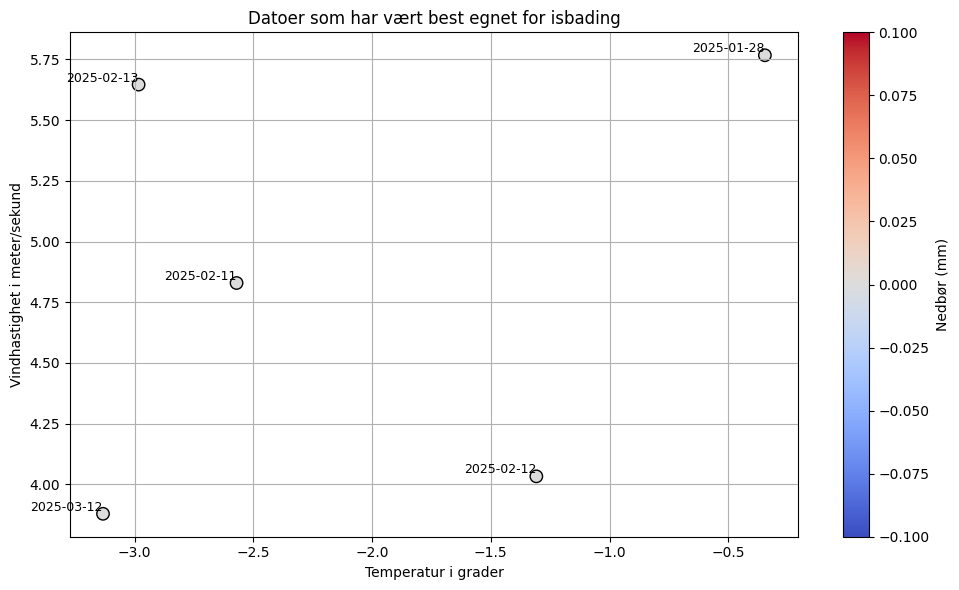

In [5]:
plott_smart_scatter_2D(
    df = df_isbading,
    x_col = "Temperatur (°C)",
    y_col = "Vindhastighet (km/t)", 
    color_col = "Nedbør (mm)", 
    x_label = "Temperatur i grader",
    y_label = "Vindhastighet i meter/sekund",
    title= "Datoer som har vært best egnet for isbading", 
    colorbar_label = "Nedbør (mm)", 
    text_labels_col = "Dato"
)

### Scatterplot i 3D

c:\Users\eriks\OneDrive\Dokumenter\C++\Python\Mappeprosjekt_felles\Milj-dataanalyseapplikasjon\notebooks\API_Weather\../../src\plot_funksjon.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dato_col] = pd.to_datetime(df[dato_col])


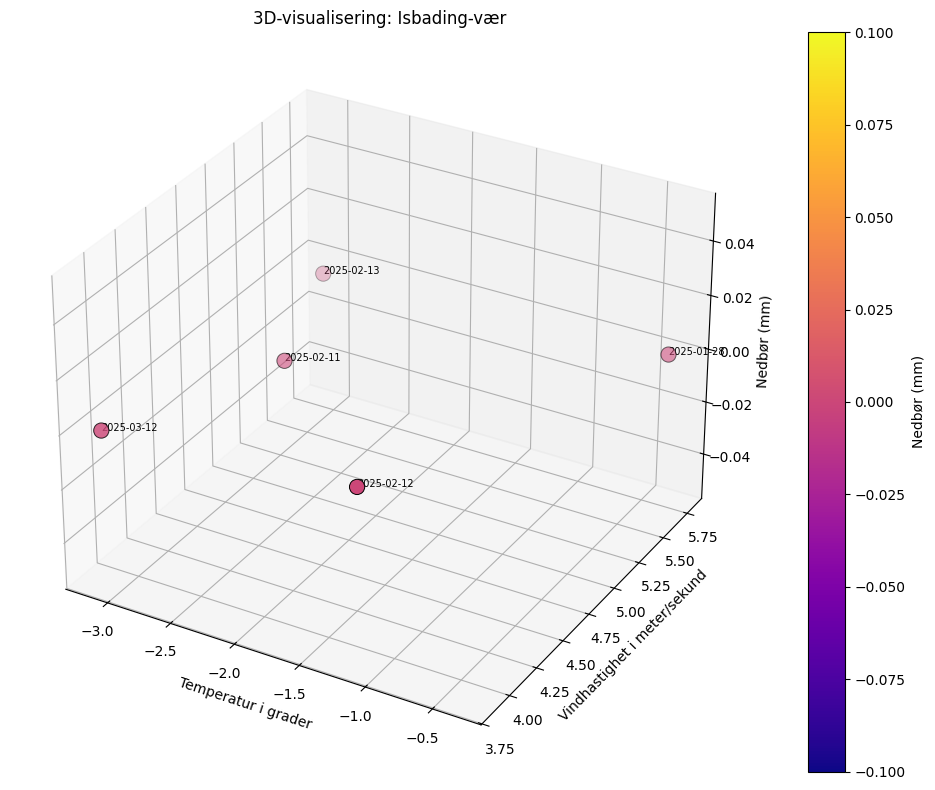

In [6]:
plott_smart_scatter_3D(
    df = df_isbading,
    x_col = "Temperatur (°C)",
    y_col = "Vindhastighet (km/t)", 
    z_col = "Nedbør (mm)", 
    dato_col = "Dato", 
    x_label = "Temperatur i grader",
    y_label = "Vindhastighet i meter/sekund",
    z_label = "Nedbør (mm)",
    title = "3D-visualisering: Isbading-vær"
)

### Sammenligner med Seaborn

<Axes: xlabel='Tidspunkt', ylabel='Måling'>

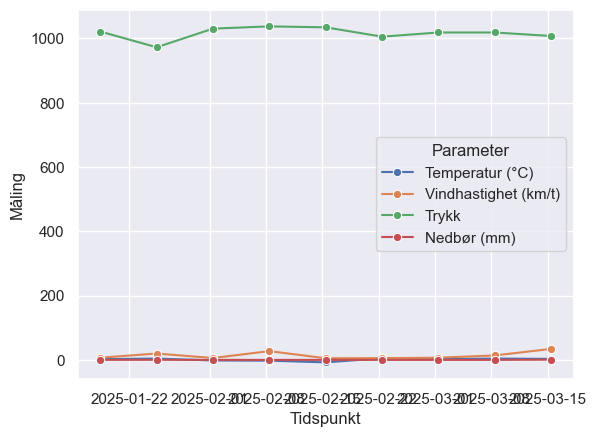

In [7]:
#Erstatter Matplotlib med seaborn
sns.set_theme(style="darkgrid")
#datasett lengre for at det skal bli enkelt og plotte
df_melted = filtered_df.melt(id_vars=['Tidspunkt'],
                             value_vars=['Temperatur (°C)', 'Vindhastighet (km/t)', 'Trykk', 'Nedbør (mm)'], 
                             var_name='Parameter', 
                             value_name='Måling')

#lager linjeplot
sns.lineplot(data=df_melted, x = 'Tidspunkt', y = 'Måling', hue='Parameter', marker="o")


### Plot for temperatur, vind, nedbør og trykk

<Figure size 1000x800 with 0 Axes>

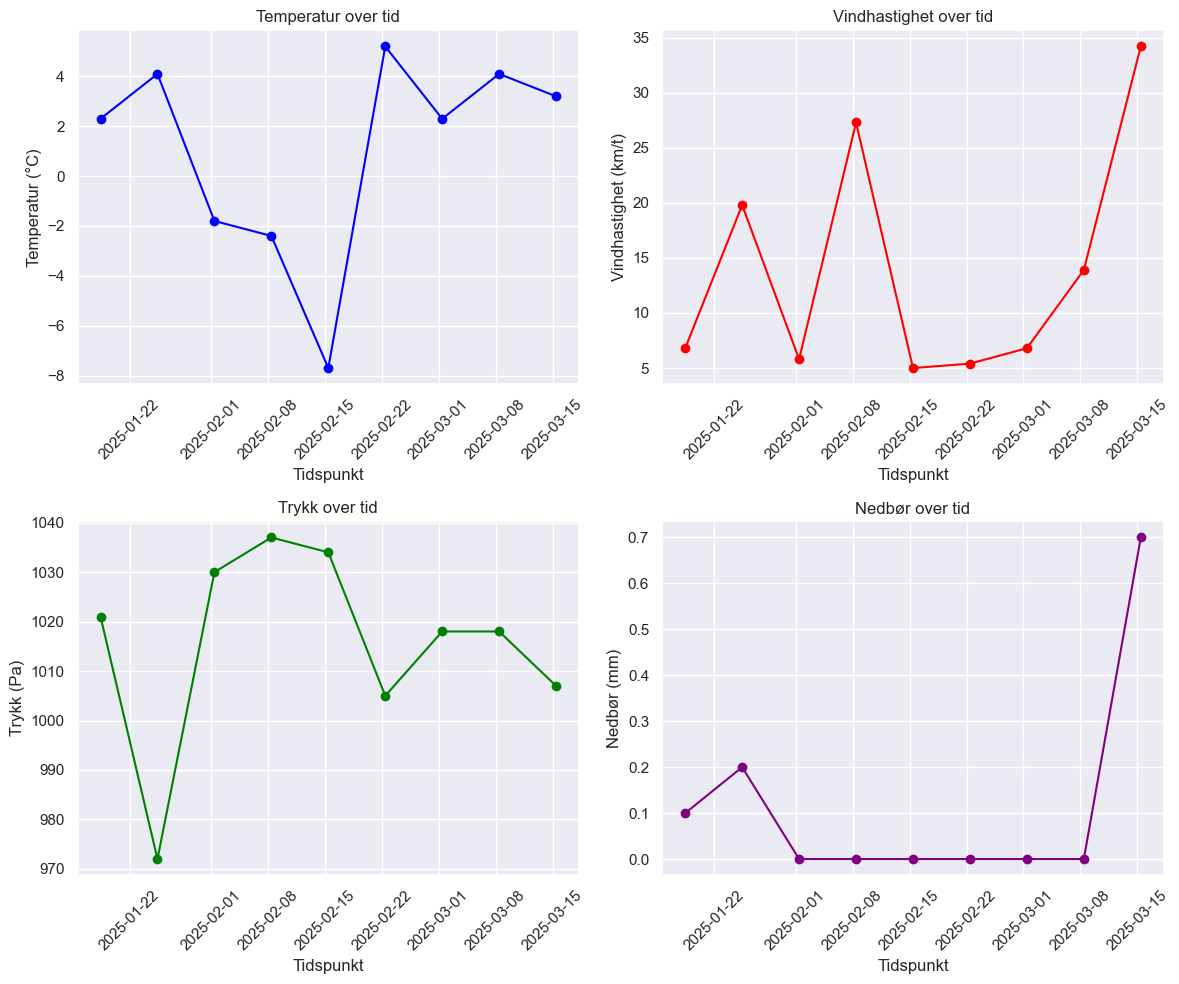

In [12]:

filtered_df['Tidspunkt'] = pd.to_datetime(filtered_df['Tidspunkt'])
plt.figure(figsize=(10, 8))#plotter

plot_config = opprett_liste_over_fire_subplots()

for config in plot_config:
    forenklet_plot_funksjon(
        df = filtered_df, 
        x_col = "Tidspunkt",
        y_col =  config["y_col"], 
        subplot_index = config["subplot_index"], 
        x_label = "Tidspunkt",
        y_label = config["y_label"],
        title = config["title"],
        farge = config["farge"], 
        xticks_rotation = 45
    )

plt.tight_layout()
plt.show()

### Sammenligning av temperatur og trykk

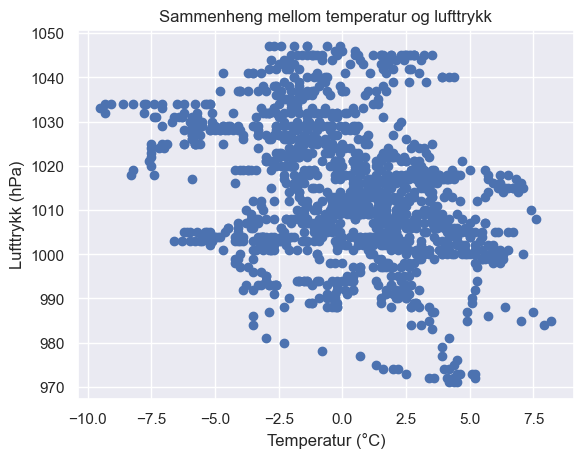

In [ ]:
#Dataanalyse mellom temperatur og trykket med scatterplot
import matplotlib.pyplot as plt

plt.scatter(df['Temperatur (°C)'], df['Trykk'])
plt.xlabel("Temperatur (°C)")
plt.ylabel("Lufttrykk (hPa)")
plt.title("Sammenheng mellom temperatur og lufttrykk")
plt.show()

### Trykkvariasjon for en gitt tidsperiode

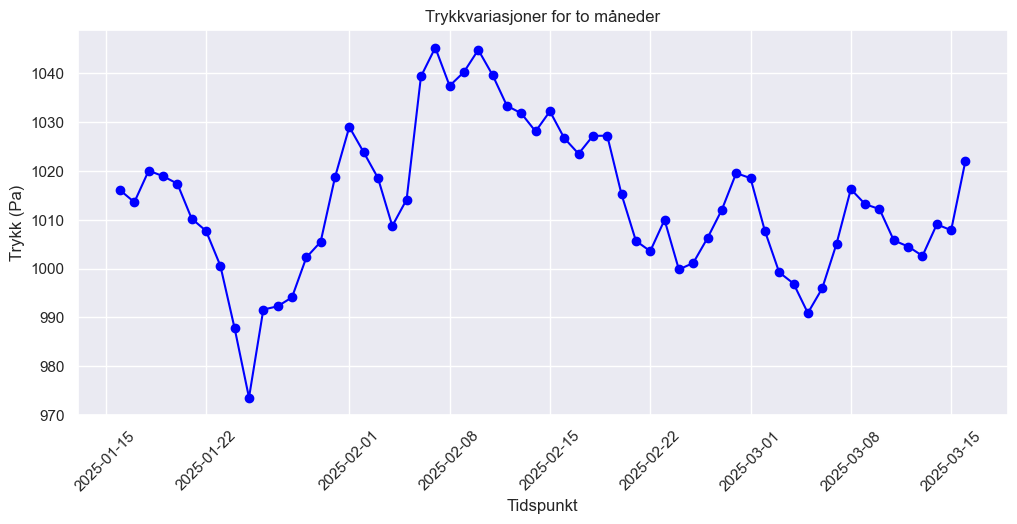

In [ ]:

file_path_6 = os.path.join("../..", "data", "trondheim_vaerdata_full_1.csv")
df = pd.read_csv(file_path_6)

df["Tidspunkt"] = pd.to_datetime(df["Tidspunkt"])
df = df.sort_values("Tidspunkt")

df = df.set_index("Tidspunkt")
#daglig snitt
df_daglig = df.select_dtypes(include='number').resample('D').mean().reset_index()



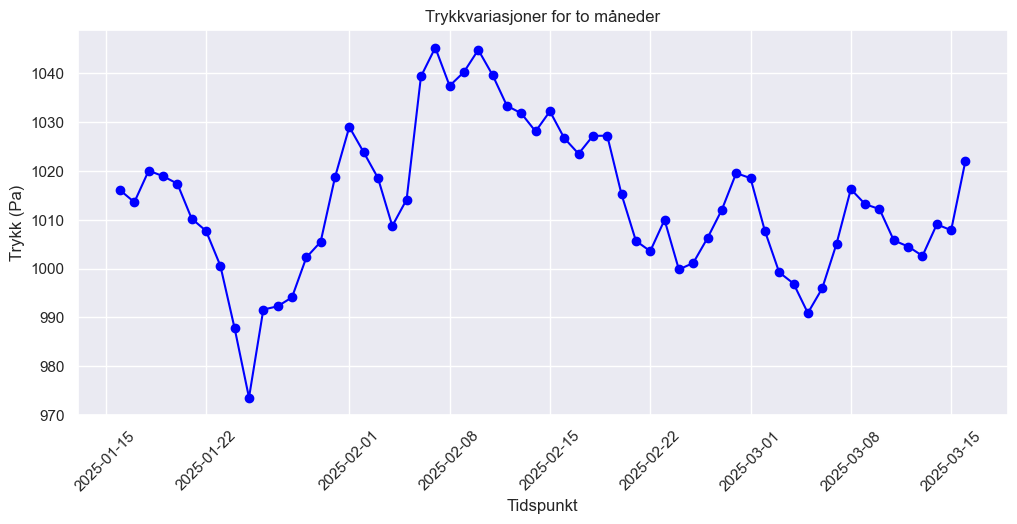

In [21]:

plt.figure(figsize=(12, 5))

forenklet_plot_funksjon(
    df = df_daglig, 
    x_col = "Tidspunkt",
    y_col =  "Trykk", 
    subplot_index = (1, 1, 1), 
    x_label = "Tidspunkt",
    y_label = "Trykk (Pa)",
    title = "Trykkvariasjoner for to måneder",
    farge = "blue", 
    xticks_rotation = 45
    
)

### Temperaturvariasjonen for en gitt tidsperiode

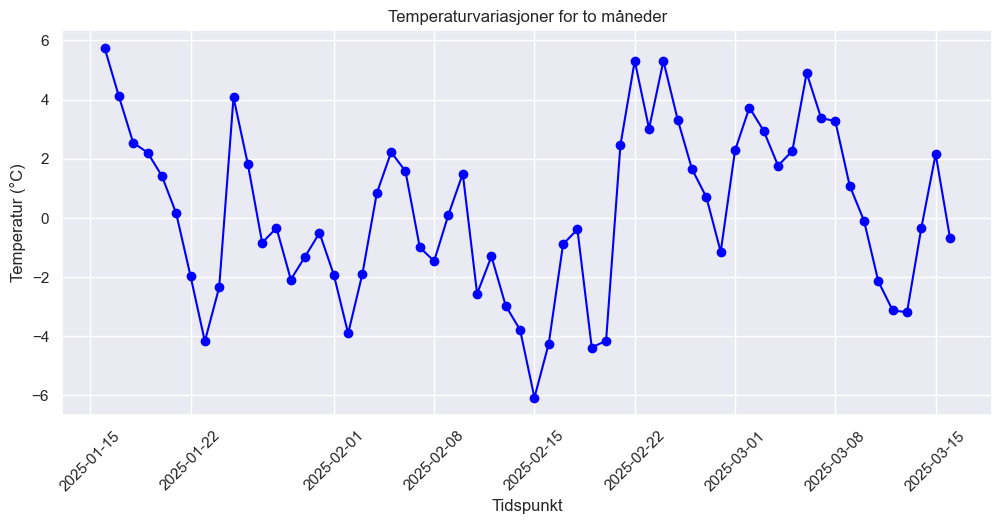

In [22]:
plt.figure(figsize=(12, 5))
forenklet_plot_funksjon(
    df = df_daglig, 
    x_col = "Tidspunkt",
    y_col =  "Temperatur (°C)", 
    subplot_index = (1, 1, 1), 
    x_label = "Tidspunkt",
    y_label = "Temperatur (°C)",
    title = "Temperaturvariasjoner for to måneder",
    farge = "blue", 
    xticks_rotation = 45
    
)

### Scatterplot av temperatur i forhold til vind

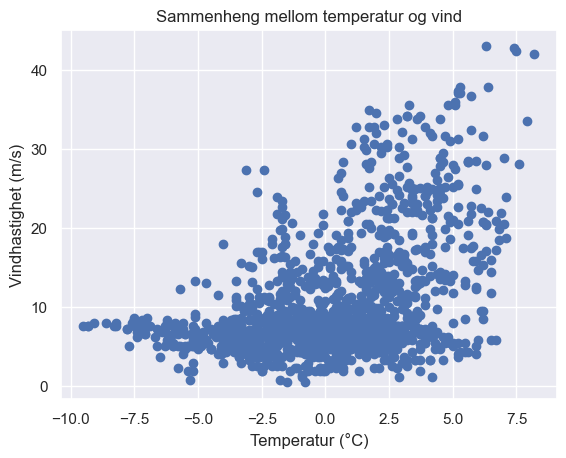

In [ ]:

plt.scatter(df['Temperatur (°C)'], df['Vindhastighet (km/t)'])
plt.xlabel("Temperatur (°C)")
plt.ylabel("Vindhastighet (m/s)")
plt.title("Sammenheng mellom temperatur og vind")
plt.show()

In [ ]:
#Lag Readme filer 
#Lag source filer
#Lag test filer



#Lukker filressurser på en trygg måte
#filepath med tall må man fikse opp
#beregne statistiske mål som gjennomsnitt og standardavvik
#Widgets, Plotly eller Bokeh
#Bading/isbading


